In [ ]:
!pip install tensorflow==2.12.0 tensorflow-hub==0.13.0

In [ ]:
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


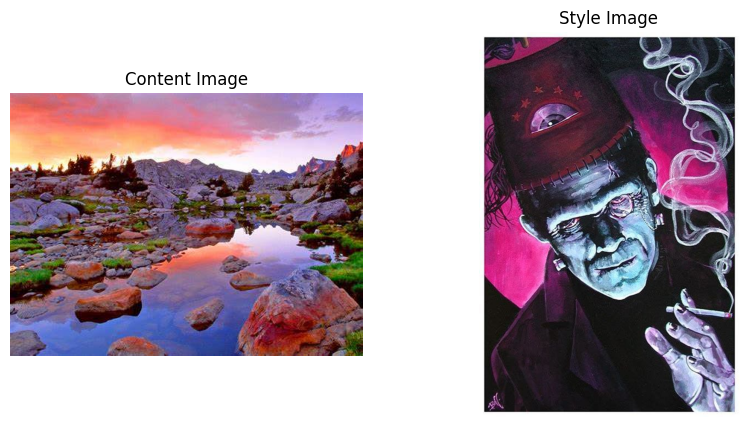

In [ ]:
import requests
from io import BytesIO

# URLs of the content and style images
content_image_url = "https://th.bing.com/th/id/OIP.1d6tBbNiJTFQNEK_k0sSjQHaFj?rs=1&pid=ImgDetMain"
style_image_url = "https://i.pinimg.com/736x/49/15/7d/49157d3d99418b298e134cd809674283.jpg"

# Function to load image from URL
def load_image_from_url(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    return img

# Load content and style images
content_image = load_image_from_url(content_image_url)
style_image = load_image_from_url(style_image_url)

# Display the images (optional)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(content_image)
plt.title('Content Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(style_image)
plt.title('Style Image')
plt.axis('off')

plt.show()


In [ ]:
# Function to preprocess image for VGG19
def preprocess_image(image):
    img = image.resize((224, 224))  # Resize to match VGG19 input size
    img = np.array(img)
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    img = tf.keras.applications.vgg19.preprocess_input(img)  # Preprocess for VGG19
    return img

# Preprocess content and style images
content_image = preprocess_image(content_image)
style_image = preprocess_image(style_image)


In [ ]:
# Load VGG19 model without the top (fully connected layers)
vgg19 = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
vgg19.trainable = False  # Freeze VGG19 weights

# Define layers for content and style representations
content_layers = ['block5_conv2']
style_layers = [
    'block1_conv1',
    'block2_conv1',
    'block3_conv1',
    'block4_conv1',
    'block5_conv1'
]

# Outputs for content and style layers
content_outputs = [vgg19.get_layer(name).output for name in content_layers]
style_outputs = [vgg19.get_layer(name).output for name in style_layers]

# Model to extract content and style features
extractor_model = tf.keras.Model(inputs=vgg19.input, outputs=content_outputs + style_outputs)

# Function to compute content and style representations
def compute_features(image, model):
    features = model(image)
    content_features = features[:len(content_layers)]
    style_features = features[len(content_layers):]
    return content_features, style_features

# Compute content and style features for content and style images
content_features, style_features = compute_features(content_image, extractor_model)
style_features_orig = style_features  # Save original style features for later use


80134624/80134624 [==============================] - 1s 0us/step


In [ ]:
# Function to compute content loss
def content_loss(content, target):
    return tf.reduce_mean(tf.square(content - target))

# Function to compute gram matrix (used for style loss)
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)
    return result / num_locations

# Function to compute style loss
def style_loss(style, target):
    style_gram = gram_matrix(style)
    target_gram = gram_matrix(target)
    return tf.reduce_mean(tf.square(style_gram - target_gram))

# Weight factors for content and style loss
alpha = 1e3  # Content weight
beta = 1e-2  # Style weight

# Function to compute total loss
def total_loss(outputs, content_targets, style_targets):
    content_outputs = outputs[:len(content_layers)]
    style_outputs = outputs[len(content_layers):]

    content_loss_value = 0.0
    style_loss_value = 0.0

    # Compute content loss
    for content, target in zip(content_outputs, content_targets):
        content_loss_value += content_loss(content, target)

    # Compute style loss
    for style, target in zip(style_outputs, style_targets):
        style_loss_value += style_loss(style, target)

    total_loss = alpha * content_loss_value + beta * style_loss_value
    return total_loss

# Compute content and style targets
content_targets = compute_features(content_image, extractor_model)[0]
style_targets = compute_features(style_image, extractor_model)[1:]


In [ ]:
# Compute content and style targets
content_targets = compute_features(content_image, extractor_model)[0]
style_targets = [tf.convert_to_tensor(t) for t in compute_features(style_image, extractor_model)[1]] # Convert list elements to tensors

Iteration 0: Total loss: 2775915776.0


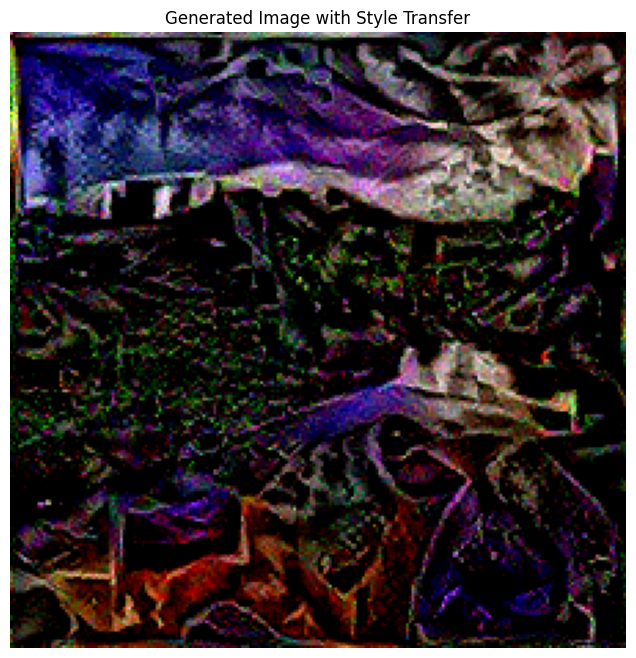

In [ ]:
# Initialize generated image with content image
generated_image = tf.Variable(content_image)

# Function to compute gradients
def compute_gradients(image):
    with tf.GradientTape() as tape:
        outputs = extractor_model(image)
        loss = total_loss(outputs, content_targets, style_targets)
    gradients = tape.gradient(loss, image)
    return loss, gradients

# Optimizer parameters
optimizer = tf.optimizers.Adam(learning_rate=5.0, beta_1=0.99, epsilon=1e-1)

# Number of iterations for optimization
iterations = 150
iterations = 100

# Optimization loop
for i in range(iterations):
    loss, gradients = compute_gradients(generated_image)
    optimizer.apply_gradients([(gradients, generated_image)])

    if i % 100 == 0:
        print(f"Iteration {i}: Total loss: {loss}")

# generated image
generated_image = np.clip(generated_image.numpy().squeeze(), 0, 255).astype(np.uint8)

# Display
plt.figure(figsize=(8, 8))
plt.imshow(generated_image)
plt.title('Generated Image with Style Transfer')
plt.axis('off')
plt.show()
